IMPORTING LIBRARIES

In [1]:
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

LOADING AND PREPROCESSING DATASET

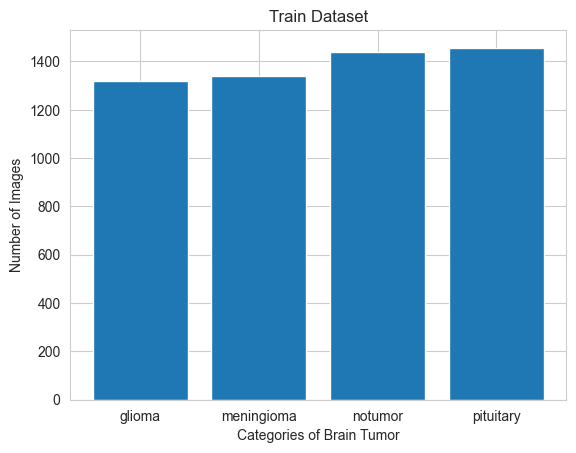

In [2]:
path1 = '/Brain tumor Detection/dataset/Training'
subfolders1 = os.listdir(path1)
subfolder_counts1 = [len(os.listdir(os.path.join(path1, subfolder))) for subfolder in subfolders1]

x_labels = subfolders1
x = range(len(x_labels))
y = subfolder_counts1
plt.bar(x, y)

plt.xticks(x, x_labels)
plt.xlabel('Categories of Brain Tumor')
plt.ylabel('Number of Images')
plt.title('Train Dataset')

plt.show()

31


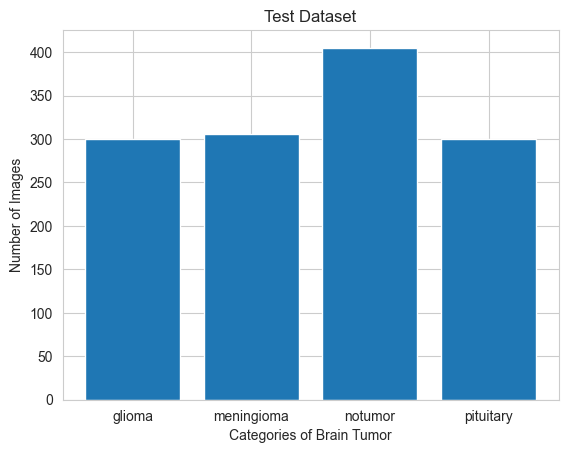

In [3]:
path2 = '/Brain tumor ml/dataset/Testing'
print(len(path2))
subfolders2 = os.listdir(path2)
subfolder_counts2 = [len(os.listdir(os.path.join(path2, subfolder))) for subfolder in subfolders2]

x_labels = subfolders2
x = range(len(x_labels))
y = subfolder_counts2
plt.bar(x, y)

plt.xticks(x, x_labels)
plt.xlabel('Categories of Brain Tumor')
plt.ylabel('Number of Images')
plt.title('Test Dataset')
plt.show()

Paths to training and testing datasets

In [4]:
train_dir = '/Brain tumor ml/dataset/Training'

test_dir = '/Brain tumor ml/dataset/Testing'

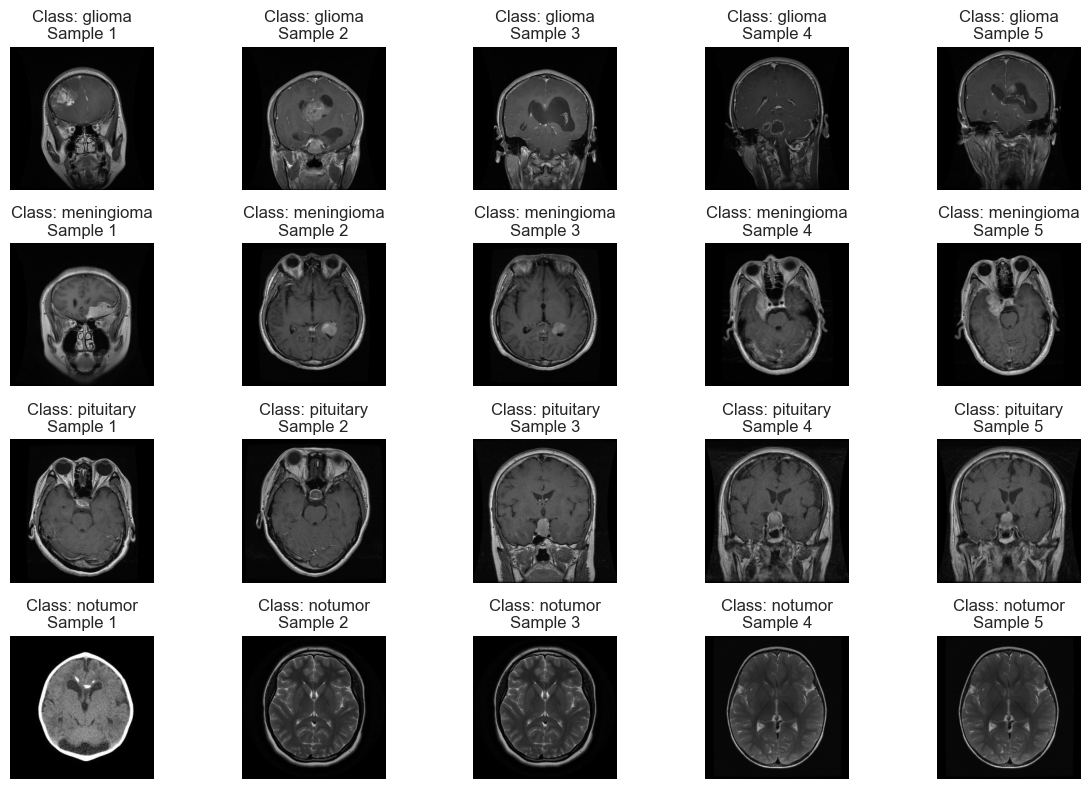

In [5]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# List of subdirectories representing different classes
class_folders = ['glioma', 'meningioma', 'pituitary', 'notumor']

plt.figure(figsize=(12, 8))

# Loop through each subdirectory and display sample images
for i, folder in enumerate(class_folders):
    sub_dir = os.path.join(train_dir, folder)
    sample_images = os.listdir(sub_dir)[:5]  # Load first 5 images from each subdirectory

    for j, image_name in enumerate(sample_images):
        img = Image.open(os.path.join(sub_dir, image_name))
        plt.subplot(4, 5, i * 5 + j + 1)
        plt.imshow(img)
        plt.title(f"Class: {folder}\nSample {j+1}")
        plt.axis('off')

plt.tight_layout()
plt.show()

Data augmentation

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

Load and preprocess training and testing data

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 5557 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


InceptionV3 Model

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Number of classes 
num_classes = 4  

# Load pre-trained InceptionV3 model 
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dense(1024, activation='relu')(x)  
predictions = Dense(num_classes, activation='softmax')(x)  

# Combine the base model and custom layers into a new model
inception_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=1e-3)
inception_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
train_features = inception_model.predict(train_generator)
test_features = inception_model.predict(test_generator)

41/41 [==============================] - 153s 4s/step


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generators (replace paths with your actual data paths)
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Adjust parameters as needed
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Replace with your training data directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Compile the model
optimizer = Adam(learning_rate=1e-3)
inception_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the data generator
history1 = inception_model.fit(train_generator, epochs=5)


Found 4447 images belonging to 4 classes.
Epoch 1/5
139/139 [==============================] - 239s 2s/step - loss: 0.6716 - accuracy: 0.7949
Epoch 2/5
139/139 [==============================] - 268s 2s/step - loss: 0.2858 - accuracy: 0.8957
Epoch 3/5
139/139 [==============================] - 294s 2s/step - loss: 0.2231 - accuracy: 0.9159
Epoch 4/5
139/139 [==============================] - 290s 2s/step - loss: 0.1912 - accuracy: 0.9296
Epoch 5/5
139/139 [==============================] - 435s 3s/step - loss: 0.1538 - accuracy: 0.9436


In [10]:
# save model and architecture to single file
inception_model.save("inception_ensemble.h5")
print("Saved model to disk")

Saved model to disk


CNN Model

In [11]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, LSTM, Flatten, Reshape
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
# Input layer for image data (assuming RGB images)
input_features = Input(shape=(224, 224, 3), name='input_features')

# Reshape the input based on your feature data (if needed)
# This line is commented out as the input shape already matches the expected format for CNNs
# reshaped_features = Reshape((32, 64, 1))(input_features)  # Adjust dimensions if necessary

# CNN layers for feature extraction from the image data
cnn_output = Conv2D(32, (3, 3), activation='relu')(input_features)
cnn_output = MaxPooling2D(pool_size=(2, 2))(cnn_output)
cnn_output = Conv2D(32, (3, 3), activation='relu')(cnn_output)
cnn_output = MaxPooling2D(pool_size=(2, 2))(cnn_output)
cnn_output = Conv2D(64, (3, 3), activation='relu')(cnn_output)
cnn_output = MaxPooling2D(pool_size=(2, 2))(cnn_output)
cnn_output = Flatten()(cnn_output)

# Reshape the flattened CNN output for Bi-LSTM (assuming time series data)
cnn_output_reshaped = Reshape((1, -1))(cnn_output)

bi_lstm_output = Bidirectional(LSTM(64, return_sequences=True))(cnn_output_reshaped)
bi_lstm_output = Bidirectional(LSTM(64, return_sequences=True))(bi_lstm_output)

# Flatten the output of Bi-LSTM
bi_lstm_output_flatten = Flatten()(bi_lstm_output)

dense_layer = Dense(128, activation='relu')(bi_lstm_output_flatten)
dense_layer = Dropout(0.5)(dense_layer)
dense_layer = Dense(64, activation='relu')(dense_layer)
output = Dense(4, activation='softmax')(dense_layer)

cnn_model = Model(inputs=input_features, outputs=output)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Convert integer labels to one-hot encoding
train_labels_one_hot = to_categorical(train_generator.classes, num_classes=4)
test_labels_one_hot = to_categorical(test_generator.classes, num_classes=4)

In [16]:
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Train the model using the data generator
history1 = cnn_model.fit(train_generator, epochs=10)

Epoch 1/50
139/139 [==============================] - 352s 2s/step - loss: 0.8346 - accuracy: 0.6155
Epoch 2/50
139/139 [==============================] - 193s 1s/step - loss: 0.4454 - accuracy: 0.8210
Epoch 3/50
139/139 [==============================] - 245s 2s/step - loss: 0.2673 - accuracy: 0.9031
Epoch 4/50
139/139 [==============================] - 251s 2s/step - loss: 0.1655 - accuracy: 0.9415
Epoch 5/50
139/139 [==============================] - 251s 2s/step - loss: 0.1359 - accuracy: 0.9544
Epoch 6/50
139/139 [==============================] - 236s 2s/step - loss: 0.0693 - accuracy: 0.9789
Epoch 7/50
139/139 [==============================] - 240s 2s/step - loss: 0.0508 - accuracy: 0.9834
Epoch 8/50
139/139 [==============================] - 591s 4s/step - loss: 0.0362 - accuracy: 0.9892
Epoch 9/50
139/139 [==============================] - 254s 2s/step - loss: 0.0363 - accuracy: 0.9874
Epoch 10/50
139/139 [==============================] - 244s 2s/step - loss: 0.0343 - accura

In [19]:
cnn_model.save("cnn_ensemble.h5")
print("Saved model to disk")

Saved model to disk


In [17]:
import numpy as np

# Check the shapes of your input data and output labels
print("Train features shape:", train_features.shape)
print("Train labels shape:", train_labels_one_hot.shape)

# Determine the number of samples in each dataset
num_samples_features = train_features.shape[0]
num_samples_labels = train_labels_one_hot.shape[0]

# If the number of samples is not the same, you may need to adjust your data
if num_samples_features != num_samples_labels:
    # Determine which dataset has fewer samples
    min_samples = min(num_samples_features, num_samples_labels)
    
    # Trim the datasets to have the same number of samples
    train_features = train_features[:min_samples]
    train_labels_one_hot = train_labels_one_hot[:min_samples]
    
    print("Number of samples adjusted. New shapes:")
    print("Train features shape:", train_features.shape)
    print("Train labels shape:", train_labels_one_hot.shape)
else:
    print("Number of samples in both datasets is consistent.")



Train features shape: (5557, 4)
Train labels shape: (5557, 4)
Number of samples in both datasets is consistent.


Ensemble Method

In [22]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
model = load_model('/Brain tumor ml/inception_ensemble.h5')
model= Model(inputs=model.inputs,
                outputs=model.outputs,
                name='InceptionV3')
model_1 = load_model('/Brain tumor ml/cnn_ensemble.h5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='CNN')
models = [model, model_1]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [23]:
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Train the model using the data generator
history2 = ensemble_model.fit(train_generator, epochs=10)

Epoch 1/10


174/174 [==============================] - 948s 5s/step - loss: 1.5940 - accuracy: 0.2566
Epoch 2/10
174/174 [==============================] - 1048s 6s/step - loss: 1.5289 - accuracy: 0.2622
Epoch 3/10
174/174 [==============================] - 1016s 6s/step - loss: 1.5254 - accuracy: 0.2622
Epoch 4/10
174/174 [==============================] - 785s 4s/step - loss: 1.4534 - accuracy: 0.2622
Epoch 5/10
174/174 [==============================] - 563s 3s/step - loss: 1.3477 - accuracy: 0.2622
Epoch 6/10
174/174 [==============================] - 631s 4s/step - loss: 1.3070 - accuracy: 0.2622
Epoch 7/10
174/174 [==============================] - 655s 4s/step - loss: 1.2424 - accuracy: 0.2622
Epoch 8/10
174/174 [==============================] - 526s 3s/step - loss: 1.2174 - accuracy: 0.2622
Epoch 9/10
174/174 [==============================] - 505s 3s/step - loss: 1.1743 - accuracy: 0.2622
Epoch 10/10
174/174 [==============================] - 515s 3s/step - loss: 1.1432 - ac